In [17]:
import os
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
sns.set_style('darkgrid')
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization


In [18]:
data_dir = 'archive/lung_colon_image_set/lung_image_sets'

In [19]:
def define_paths(data_dir):
    filepaths = []
    labels = []
    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def create_df(data_dir):
   
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    
    strat=df['labels']
    train_df, dummy_df=train_test_split(df,  train_size=0.8, shuffle=True, random_state=123, stratify=strat)
    
    strat = dummy_df['labels']
    valid_df, test_df=train_test_split(dummy_df,  train_size=0.5, shuffle=True, random_state=123, stratify=strat)
    return train_df, valid_df, test_df


In [20]:
train_df, valid_df, test_df = create_df(data_dir)

In [23]:
batch_size = 40
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
def scalar(img):
    return img
tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)
valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 4799 validated image filenames belonging to 3 classes.
Found 600 validated image filenames belonging to 3 classes.
Found 601 validated image filenames belonging to 3 classes.


C:\Users\Dhruv Kothari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


In [24]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization_4 (Batc  (None, 1536)             6144      
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 256)               393472    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 3)                 771       
                                                                 
Total params: 11,183,922
Trainable params: 11,093,547
Non-trainable params: 90,375
_____________________________________

In [25]:
batch_size = 100
hist = model.fit(train_gen,
                 steps_per_epoch=train_gen.samples//batch_size,
                 validation_data=valid_gen,
                 validation_steps=valid_gen.samples//batch_size,
                 epochs=1)

47/47 [==============================] - 1674s 34s/step - loss: 7.4006 - accuracy: 0.8686 - val_loss: 8.0726 - val_accuracy: 0.5542


In [27]:
train_score = model.evaluate(train_gen)
valid_score = model.evaluate(valid_gen)
test_score = model.evaluate(test_gen)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

601/601 [==============================] - 58s 96ms/step - loss: 7.7084 - accuracy: 0.6240
Train Loss:  7.75068473815918
Train Accuracy:  0.6178370714187622
--------------------
Validation Loss:  7.786435604095459
Validation Accuracy:  0.6133333444595337
--------------------
Test Loss:  7.708428859710693
Test Accuracy:  0.6239600777626038


In [28]:
batch_size = 100
target_names = ['adenocarcinoma', 'benign', 'squamous cell carcinoma']
Y_pred = model.predict_generator(test_gen)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)

C:\Users\Dhruv Kothari\AppData\Local\Temp\ipykernel_22580\2659987924.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_gen)


[0 2 1 2 2 2 2 1 2 2 2 0 1 2 2 2 2 1 1 2 0 2 0 2 2 0 2 2 1 2 2 1 0 1 2 1 2
 1 1 2 0 0 1 1 1 0 2 1 0 2 2 2 0 0 2 2 1 1 2 1 2 0 2 2 2 2 0 0 2 0 1 0 1 2
 2 2 2 2 2 0 2 2 2 2 0 1 1 1 2 2 2 2 1 2 2 2 2 2 0 1 1 0 2 2 2 1 2 1 2 1 2
 1 2 2 2 1 2 2 2 0 2 1 1 0 1 0 2 2 1 2 2 2 2 0 2 2 2 0 1 2 1 2 1 2 1 2 2 2
 2 2 2 2 2 2 2 1 1 1 0 2 2 0 2 0 1 1 2 2 2 2 2 0 2 1 2 2 2 2 2 1 2 0 2 2 2
 2 1 2 1 0 1 0 2 1 2 1 0 2 1 2 0 2 0 2 0 2 0 0 0 0 0 2 1 2 2 2 1 2 1 1 2 2
 2 2 2 2 0 0 1 2 2 2 0 2 0 0 2 2 2 2 0 1 2 0 0 0 1 0 2 2 0 2 2 1 2 1 1 1 2
 2 1 1 2 2 2 2 0 2 0 2 2 1 2 2 1 2 2 2 2 2 2 1 2 2 2 1 2 2 2 0 2 1 1 2 2 0
 1 1 2 2 2 2 2 1 2 0 2 2 2 2 2 1 0 2 2 2 2 2 2 2 1 2 2 1 2 2 2 2 2 0 0 1 0
 1 1 2 2 2 0 2 1 0 1 2 0 2 0 1 2 2 1 2 2 0 0 1 2 2 2 0 2 2 0 2 2 1 0 2 2 0
 1 0 2 2 0 2 1 2 1 2 0 2 2 0 2 1 2 2 2 2 0 2 0 2 2 2 2 1 0 1 0 1 1 2 2 2 2
 1 2 2 2 1 0 0 0 1 0 2 2 1 2 1 0 1 2 2 2 2 1 2 1 1 0 2 2 2 0 0 2 2 2 0 2 2
 2 1 2 1 1 0 2 2 0 2 2 2 2 2 1 2 1 1 1 2 0 2 2 2 2 2 1 2 0 2 1 2 2 1 0 0 2
 2 0 2 2 2 2 1 2 2 1 1 2 

In [29]:
cm = confusion_matrix(test_gen.classes, y_pred)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap = plt.cm.Blues):
  plt.figure(figsize=(10, 10))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized Confusion Matrix')
  else:
    print('Confusion Matrix, Without Normalization')
  
  print(cm)

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color = 'white' if cm[i, j] > thresh else 'black')

  plt.tight_layout()
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')

Confusion Matrix, Without Normalization
[[ 51  18 132]
 [ 70 124   6]
 [  0   0 200]]


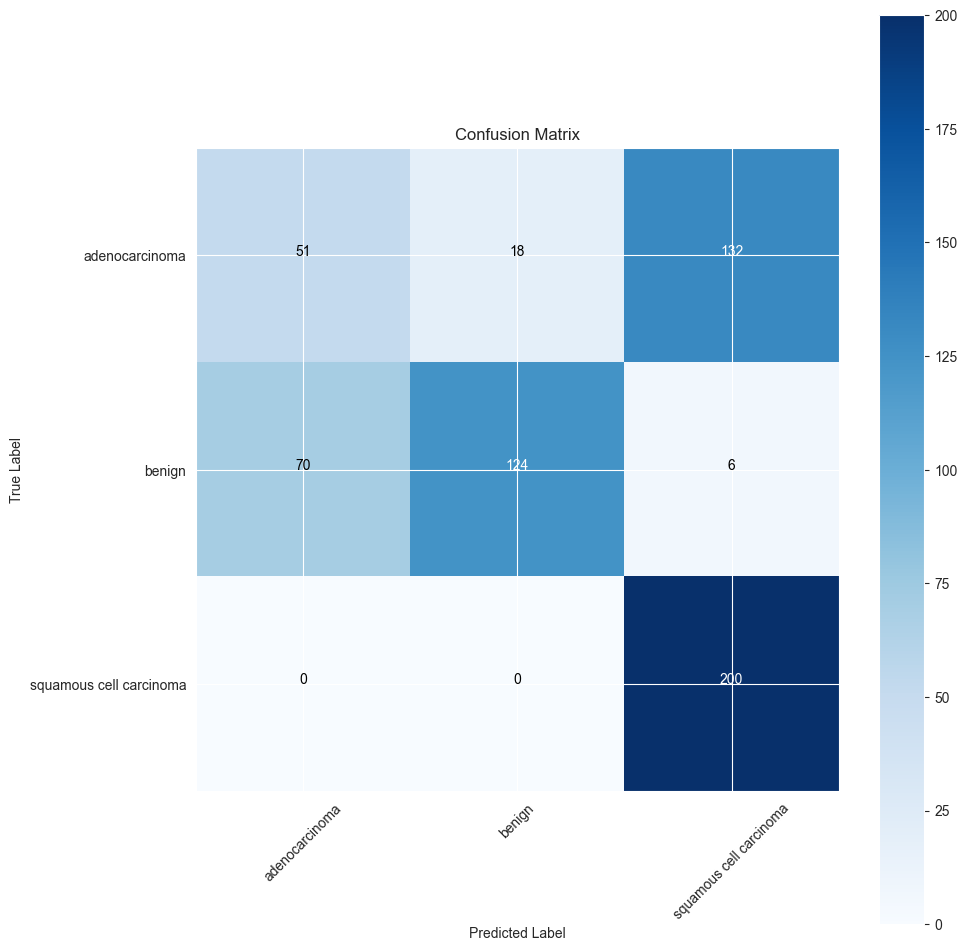

In [30]:
plot_confusion_matrix(cm=cm, classes=target_names, title = 'Confusion Matrix')

In [31]:
from sklearn.metrics import classification_report
print(classification_report(test_gen.classes, y_pred, target_names=target_names))

                         precision    recall  f1-score   support

         adenocarcinoma       0.42      0.25      0.32       201
                 benign       0.87      0.62      0.73       200
squamous cell carcinoma       0.59      1.00      0.74       200

               accuracy                           0.62       601
              macro avg       0.63      0.62      0.60       601
           weighted avg       0.63      0.62      0.59       601

